<h3 align="center" style="margin:0px">
    <img width="200" src="../_assets/images/logo_purple.png" alt="Kinetica Logo"/>
</h3>
<h5 align="center" style="margin:0px">
    <a href="https://www.kinetica.com/">Website</a>
    <span> | </span>
    <a href="https://docs.kinetica.com/7.1/">Docs</a>
    <span> | </span>
    <a href="https://docs.kinetica.com/7.1/api/">API Docs</a>
    <span> | </span>
    <a href="https://join.slack.com/t/kinetica-community/shared_invite/zt-1bt9x3mvr-uMKrXlSDXfy3oU~sKi84qg">Community Slack</a>   
</h5>

# Vector Similarity Search Demo

Learn how to use the Kinetica similarity search with the vector column type to make stock predictions. We will finish with a matplotlib visualization of the results.

## Overview

In this example we will make use of a vector embedding table containing stock 10 day stock windows. If we have an example window that we are interested in we can use the functionality to find other similar stock windows to assist with predictions.

We will choose one of the stock windows and use a similarity search to find other stock windows in the table. We will then use a visualization to compare the search vector with the results.

## Prerequisites

This demo is a continuation of the [Python Vector I/O](python_vector_io.ipynb) demo. You will need to run the other notebook to load the `demo.emb_vec_multi` table.

## Vector Function Cheat Sheet

For a complete description of vector functionality see the [Vector Search](https://docs.kinetica.com/7.2/vector_search/) documentation.

### Operators

- `==      (v1 == v2)`
- `!=      (v1 != v2)`
- `+      (v1 + v2)` 
- `-       (v1 - v2)`
- `*       (v1 * c)`
- `/       (v1 / c)`

### Scalar Functions

- size()
- nth()
- l1_norm()
- l2_norm()
- lp_norm()
- linf_norm()

### Distance Functions

- l1_distance()
- l2_distance()
- l2_squareddistance()
- lp_distance()
- linf_distance()
- dot_product()
- cosine_distance()

## Setup

The next cell will install necessary dependencies.

In [1]:
# install Kinetica package
%pip install -U -q 'gpudb>=7.2' typeguard 

# install packages needed by this notebook
%pip install -U -q pandas pyarrow matplotlib

# install packages needed for Jupyter widgets
%pip install -U -q ipykernel ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Get a Kinetica DB connection

In [2]:
from gpudb import GPUdb
import os

HOST = os.environ['KINETICA_URL']
USER = os.environ['KINETICA_USER']
PASSWORD = os.environ['KINETICA_PASSWD']

def create_kdbc(host: str, login: str, password: str) -> GPUdb:
    options = GPUdb.Options()
    options.username = login
    options.password = password
    options.skip_ssl_cert_verification = True
    options.disable_failover = True
    options.logging_level = 'INFO'
    kdbc = GPUdb(host=host, options = options)
    from importlib.metadata import version
    print(f"Connected to {kdbc.get_url()}. (api={version('gpudb')} server={str(kdbc.server_version)})")
    return kdbc

KDBC = create_kdbc(host=HOST, login=USER, password=PASSWORD)

# Table we will use
TABLE_NAME = "demo.emb_vec_multi"

Connected to http://172.31.33.30:9191. (api=7.2.0.1 server=7.2.0.1)


## Examples

### Query a summary of the stocks and counts

In [3]:
KDBC.to_df(f"""select stock, count(1) as num_rows 
            from {TABLE_NAME}
            group by stock
            order by stock;""")

,stock,num_rows
0,AAPL,1430
1,AMZN,830
2,GOOG,565
3,MSFT,1238
4,NVDA,768
5,TEAM,152


### Similarity search on a vector in the table

In this example we use a self join to compare one vector in the table with the entire table.

In [4]:
# We pass in the vector we are querying as a SQL parameters for with the data and size of the vector.
out_df = KDBC.to_df(f"""
select 
    l2_distance(emb2.literal_vec, emb.literal_vec) as dist,
    emb.window_name,
    emb.literal_vec
from {TABLE_NAME} as emb
join {TABLE_NAME} as emb2
    on emb2.window_name = 'NVDA_2001-10-18_2001-12-20'
ORDER by 1 asc
limit 5;
""")

# The first result with dist=0 should be the one we are searching with.
out_df

,dist,window_name,literal_vec
0,0.0,NVDA_2001-10-18_2001-12-20,"[13.9, 14.486667, 14.28, 14.786667, 14.412222,..."
1,13.326594,NVDA_2006-02-14_2006-04-18,"[14.683333, 14.71, 14.68, 14.993333, 15.273334..."
2,13.883753,NVDA_2006-07-24_2006-09-25,"[12.286667, 13.04, 13.2, 13.5, 13.5, 13.5, 13...."
3,14.753664,MSFT_1997-12-20_1998-02-21,"[16.109375, 16.015625, 16.125, 15.9453125, 16...."
4,15.799947,AMZN_2002-08-27_2002-10-29,"[15.04, 14.52, 14.48, 14.57, 14.43, 15.14, 14...."


### Retrieve a single vector

In [5]:
query_df = KDBC.to_df(f"""
select
    emb.window_name,
    emb.literal_vec
from {TABLE_NAME} as emb
where emb.window_name = 'NVDA_2001-10-18_2001-12-20'
""")

query_row = query_df.loc[0]

# get the dimensions of the vector
print(f"Vector dimensions: {query_row['literal_vec'].shape}")

query_row

Vector dimensions: (128,)


window_name                           NVDA_2001-10-18_2001-12-20
literal_vec    [13.9, 14.486667, 14.28, 14.786667, 14.412222,...
Name: 0, dtype: object

### Find a vector using SQL paramteres.

In this example we will use the previously retrieved vector as the input to the similarity search.

In [6]:
# We declare a vector parameter as 'VECTOR($1, $2)'. We need to pass the vector and its size.
sql = f"""
select 
    l2_distance(VECTOR($1, $2), emb.literal_vec) as dist,
    emb.window_name,
    emb.literal_vec
from {TABLE_NAME} as emb
ORDER by 1 asc
limit 5;
"""

# We pass in the vector we are querying as a SQL parameters for with the data and size of the vector.
in_vec = query_row['literal_vec']
out_df = KDBC.to_df(sql, sql_params=[ list(in_vec), len(in_vec) ])

# The first result with dist=0 should be the one we are searching with.
out_df

,dist,window_name,literal_vec
0,0.0,NVDA_2001-10-18_2001-12-20,"[13.9, 14.486667, 14.28, 14.786667, 14.412222,..."
1,13.326594,NVDA_2006-02-14_2006-04-18,"[14.683333, 14.71, 14.68, 14.993333, 15.273334..."
2,13.883753,NVDA_2006-07-24_2006-09-25,"[12.286667, 13.04, 13.2, 13.5, 13.5, 13.5, 13...."
3,14.753664,MSFT_1997-12-20_1998-02-21,"[16.109375, 16.015625, 16.125, 15.9453125, 16...."
4,15.799947,AMZN_2002-08-27_2002-10-29,"[15.04, 14.52, 14.48, 14.57, 14.43, 15.14, 14...."


## Visualize results

### Create visualization helper functions

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

def plot_stock_col(axis: plt.Axes, 
                  vis_col: str, 
                  query_row: pd.Series, 
                  result_df: pd.DataFrame) -> None:
    """ Visualize an embedding column. """

    axis.set_xlabel("Days in time window")
    axis.set_ylabel("Stock values")
    axis.title.set_text(f'Visualization of {vis_col}')
    x_index = np.arange(start=0, stop=len(query_row[vis_col]), step=1)

    # plot the query row
    query_style = dict(marker=None, linewidth=3)
    axis.plot(x_index, query_row[vis_col], label = query_row['window_name'], **query_style)

    # plot the results
    results_style = dict(marker=None, linestyle='-', alpha=0.7)
    for index, row in result_df.iterrows():
            axis.plot(x_index, row[vis_col], label = row['window_name'], **results_style)


def plot_window_compare(query_row: pd.Series, result_df: pd.DataFrame) -> None:
    """ Plot a comparison between the query row and the results. """
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.style.use('ggplot')
    #plt.style.use('dark_background')

    fig, (ax_literal) = plt.subplots(
        nrows=1, ncols=1, 
        sharex=True, 
        figsize=(20,7), 
        layout='constrained')
    
    plot_stock_col(ax_literal, 'literal_vec', query_row, result_df)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()


### Visualize the actual vector compared to the ones we found

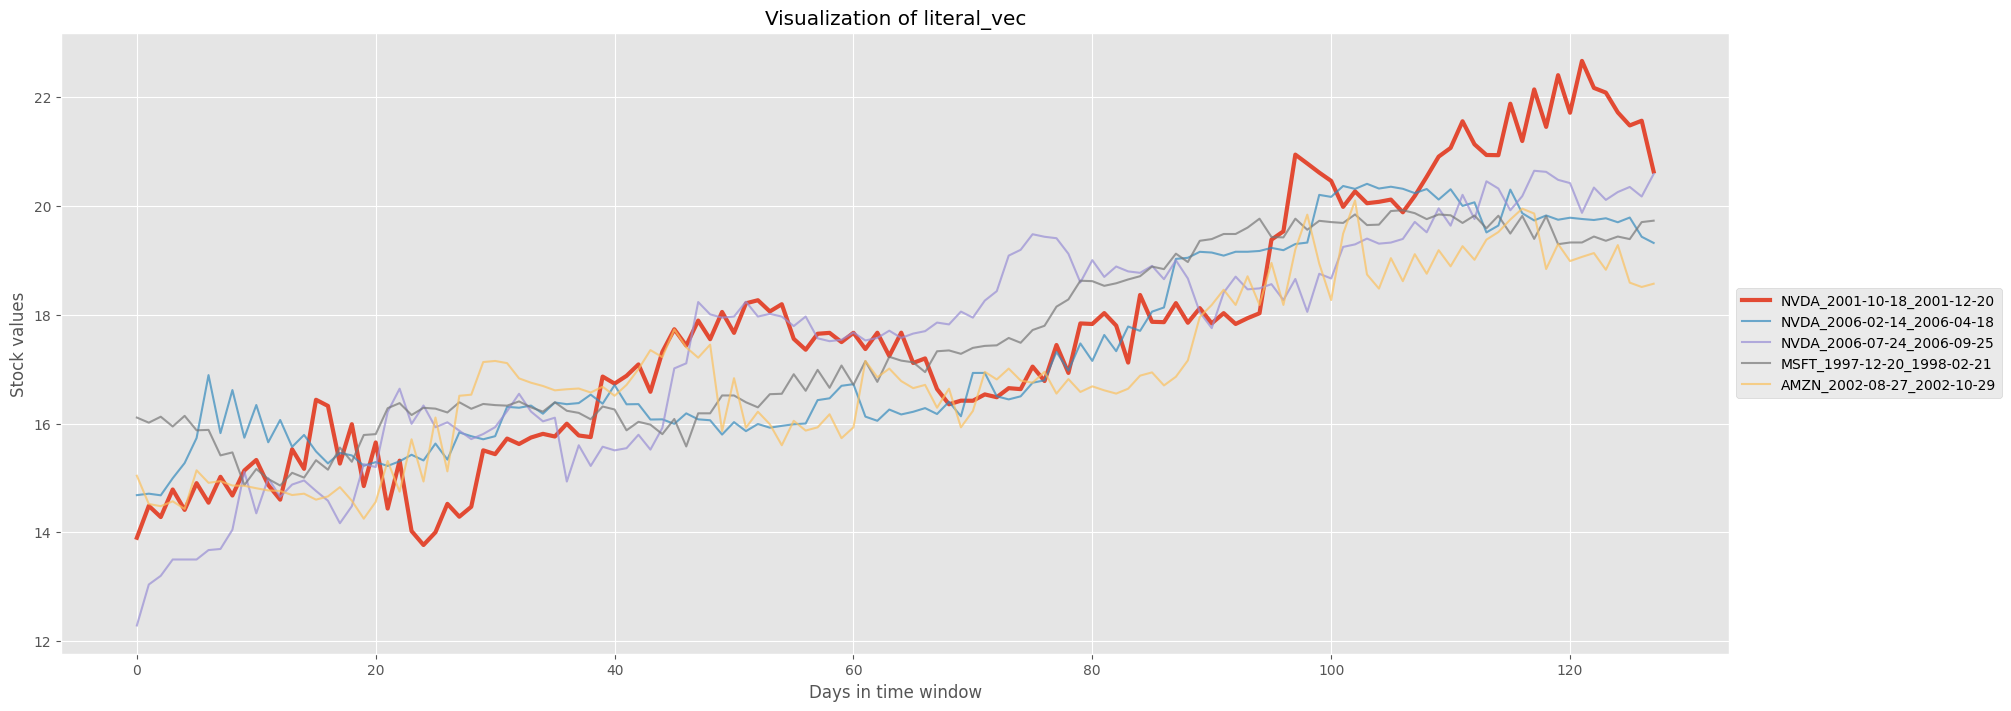

In [8]:
plot_window_compare(query_row, out_df[1:])